In [2]:
from numpy.random import normal
from math import sqrt
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import torch
import torchvision.transforms as transforms
import os
from torch.autograd import Variable
import torch.utils.data as Data
from torch.utils.data import Dataset
from PIL import Image, ImageChops
import matplotlib.pyplot as plt
import torchvision
import warnings
torch.set_default_tensor_type(torch.FloatTensor)
import copy
import random
warnings.filterwarnings("ignore")

In [3]:
def setup_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True
    random.seed(seed)

setup_seed(20)

In [4]:
class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):      
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        intersection = (inputs * targets).sum()                            
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        
        return 1 - dice
Dice=DiceLoss()
class BCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(BCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):       
        inputs = inputs.view(-1)
        targets = targets.view(-1)        
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        
        return BCE
BCE=BCELoss()
class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        inputs = F.sigmoid(inputs)       
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice_loss = 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        Dice_BCE = BCE + dice_loss
        
        return Dice_BCE

Dice_BCE=DiceBCELoss()

MSE=nn.MSELoss()

def IoUAcc(inputs, targets, smooth=1):
   
    inputs = inputs.view(-1)
    targets = targets.view(-1)        
        
    intersection = (inputs * targets).sum()
    total = (inputs + targets).sum()
    union = total - intersection 
        
    IoU = (intersection + smooth)/(union + smooth)
                
    return IoU.cpu().detach().numpy() 

In [5]:
def make_txt_file(path):
    
    # Classes: train, eval, test
    img_path=os.path.join(path,'TrainVal_images')
    label_path=os.path.join(path,'TrainVal_parsing_annotations')
    train_data=open('train.txt', 'w')
    eval_data=open('eval.txt','w')
    test_data=open('test.txt','w')
    train_data.truncate()
    eval_data.truncate()
    test_data.truncate()
    train_id=open(os.path.join(path,'train_id.txt'))
    val_id=open(os.path.join(path,'val_id.txt'))
    
    train_data_path=os.path.join(img_path,'train_images')
    val_data_path=os.path.join(img_path,'val_images')
    train_label_path=os.path.join(label_path,'train_segmentations')
    val_label_path=os.path.join(label_path,'val_segmentations')
    
    lines=train_id.readlines()
    count=0
    for line in lines:
        
        line=line.strip()
        name=os.path.join(train_data_path,line+'.jpg')+'*'+os.path.join(train_label_path,line+'.png')+'\n'
        train_data.write(name)
        count+=1
        
        if count>=4000:
            break
    train_data.close()
    train_id.close()
    
    lines=val_id.readlines()
    s=0
    count=0
    for line in lines:
        line=line.strip()
        name=os.path.join(val_data_path,line+'.jpg')+'*'+os.path.join(val_label_path,line+'.png')+'\n'
        if s%2==0:
            eval_data.write(name)
        else:
            test_data.write(name)
        s+=1
        
        count+=1
        if count>=2000:
            break
            
    val_id.close() 
    eval_data.close()
    test_data.close()
                


In [6]:
class MyDataSet(Dataset):
    def __init__(self, dataset_type, transform=None,update_dataset=False):
        """
        dataset_type: [train, eval, test]
        """
 
        dataset_path = '/kaggle/input/pil-data/LIP'
        read_path=''
 
        if update_dataset:
            make_txt_file(dataset_path) 
 
        self.transform = transform
        self.sample_list = list()
        self.dataset_type = dataset_type
        f = open(os.path.join(read_path , self.dataset_type + '.txt'))
        lines = f.readlines()
        for line in lines:
            self.sample_list.append(line.strip())
        f.close()
 
    def __getitem__(self, index):
        item = self.sample_list[index]
        img = Image.open(item.split('*')[0]).convert('RGB')       
        label = Image.open(item.split('*')[1]).convert('L')
        
        if self.transform is not None:
            img,label = self.transform(img,label)
           
        return img, label
 
    def __len__(self):
        return len(self.sample_list)

In [7]:
def train_transform(data,label):
    data=transforms.functional.resize(data,(256,256))
    label=transforms.functional.resize(label,(256,256))  
    if np.random.rand()>0.7:
        data=transforms.ColorJitter(brightness=0.1, contrast=0.1, hue=0.1)(data)
    if np.random.rand()>0.5:
        data=transforms.functional.hflip(data)
        label=transforms.functional.hflip(label)
    if np.random.rand()>0.8:
        data=transforms.functional.vflip(data)
        label=transforms.functional.vflip(label)    

    data=transforms.functional.to_tensor(data).float()
    
    label=np.array(label)
    label=(label>=1).astype(int) 
    label=transforms.functional.to_tensor(label).float()
    return data,label

def test_transfrom(data,label):
    data=transforms.functional.resize(data,(256,256))
    label=transforms.functional.resize(label,(256,256))
    data=transforms.functional.to_tensor(data).float()

    label=np.array(label)
    label=(label>=1).astype(int)  
    label=transforms.functional.to_tensor(label).float()
    return data,label
    

In [8]:
train_data=MyDataSet('train',transform=train_transform,update_dataset=True)
eval_data=MyDataSet('eval',test_transfrom)

In [9]:
class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3,padding=1),
            nn.BatchNorm2d(out_ch), 
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3,padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )
 
    def forward(self, input):        
        return self.conv(input)

In [10]:
class UNet(nn.Module):
    def __init__(self,colordim =1):
        super(UNet, self).__init__()
        self.conv1=DoubleConv(3,64)
        self.conv2=DoubleConv(64,128)
        self.conv3=DoubleConv(128,256)
        self.conv4=DoubleConv(256,512)
        
        self.conv5=DoubleConv(512,1024)
        self.upconv5=nn.Conv2d(1024, 512, 1)
        
        self.conv6=DoubleConv(1024,512)
        self.upconv6=nn.Conv2d(512, 256, 1)
        self.conv7=DoubleConv(512,256)
        self.upconv7=nn.Conv2d(256,128, 1)
        self.conv8=DoubleConv(256,128)
        self.upconv8=nn.Conv2d(128,64, 1)
        self.conv9=DoubleConv(128,64)
        
        self.maxpool=nn.MaxPool2d(2, stride=2)
        self.upsample = nn.UpsamplingBilinear2d(scale_factor=2)

        self.output=nn.Sequential(
            nn.Conv2d(64, colordim, 1),
            nn.Sigmoid()
        )
        self._initialize_weights()
    
    def forward(self, x):
        x1=self.conv1(x)
        x2=self.conv2(self.maxpool(x1))
        x3=self.conv3(self.maxpool(x2))
        x4=self.conv4(self.maxpool(x3))
        upx=self.conv5(self.maxpool(x4))
        
        upx=self.upconv5(self.upsample(upx))     

        upx=self.conv6(torch.cat((x4, upx), 1))
        upx=self.upconv6(self.upsample(upx))   

        upx=self.conv7(torch.cat((x3, upx), 1))
        upx=self.upconv7(self.upsample(upx))  

        upx=self.conv8(torch.cat((x2, upx), 1))
        upx=self.upconv8(self.upsample(upx)) 

        upx=self.conv9(torch.cat((x1, upx), 1))
        upx=self.output(upx)
        
        return upx
        
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, sqrt(2. / n))
                if m.bias is not None:
                    m.bias.data.zero_()
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()        
        
        

In [13]:
def train_model(unet,loss_func,Acc):
    setup_seed(20)
    
    EPOCH = 50
    BATCH_SIZE=32
    LR=0.001

    optimizer=torch.optim.Adam(unet.parameters(),lr=LR)
    scheduler=torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, 
        verbose=True, threshold=0.0001, threshold_mode='rel', cooldown=2, min_lr=1e-08, eps=1e-08)
    train_loader=Data.DataLoader(dataset=train_data,batch_size=BATCH_SIZE,
                                 shuffle=True, num_workers=2)
    eval_loader=Data.DataLoader(dataset=eval_data,batch_size=BATCH_SIZE,
                                 shuffle=True, num_workers=2)
    train_losses=[]    
    eval_losses=[]
    train_acc=[]
    eval_acc=[]
    


    for epoch in range(EPOCH):
        print('Epoch: %4s'%epoch)

        acc=0
        batch_loss=0
        unet.train()  

        for step,(x,y) in enumerate(train_loader):
            b_x=Variable(x).cuda()
            b_y=Variable(y).cuda()

            output=unet(b_x)   
            loss=loss_func(output,b_y)            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step() 
            batch_loss+=loss.item()
            torch.cuda.empty_cache() 
            acc+=Acc(output,b_y)*b_y.size(0)

        train_loss=batch_loss/(step+b_y.size(0)/BATCH_SIZE)
        acc=acc/4000
        train_losses.append(train_loss)
        train_acc.append(acc)
        scheduler.step(train_loss) 
        del b_x
        del b_y

        print('| train loss: %6s'%train_loss,'| train acc: %6s'%acc)



        with torch.no_grad():
            unet.eval()         

            batch_loss=0
            for step,(x,y) in enumerate(eval_loader):
                b_x=Variable(x).cuda()
                b_y=Variable(y).cuda()    
                output=unet(b_x)  
                batch_loss+=loss_func(output,b_y).item()            
                torch.cuda.empty_cache()            
                acc+=Acc(output,b_y)*b_y.size(0)

            eval_loss=batch_loss/(step+b_y.size(0)/BATCH_SIZE)
            acc=acc/1000
            eval_losses.append(eval_loss)
            eval_acc.append(acc)
            del b_x
            del b_y

        print('| eval loss: %6s'%eval_loss,'| eval acc: %6s'%acc) 
        
    return train_losses,eval_losses,train_acc,eval_acc,copy.deepcopy(unet.state_dict())

In [15]:
Accuracies=[]
Losses=[]

loss_funcs=[Dice]
names=['DiceLoss']

for i in range(len(loss_funcs)):
    torch.cuda.empty_cache()

    
    unet =UNet().cuda()
    unet.load_state_dict(torch.load('../input/dice-weight/Dice_2000_100.pkl'))
    train_losses,eval_losses,train_acc,eval_acc,weight=train_model(unet,loss_funcs[i],IoUAcc)
    torch.save(weight,'w'+str(i)+'.pkl')
    del weight
    del unet
    torch.cuda.empty_cache() 
    Accuracies.append([train_acc,eval_acc])
    Losses.append([train_losses,eval_losses])

    

Epoch:    0
| train loss: 0.1713864607810974 | train acc: 0.7081219506263733
| eval loss: 0.15787831687927245 | eval acc: 0.7347404534173012
Epoch:    1
| train loss: 0.16580632257461547 | train acc: 0.7162239742279053
| eval loss: 0.1580810317993164 | eval acc: 0.7338490088176727
Epoch:    2
| train loss: 0.16599449253082274 | train acc: 0.7159855780601502
| eval loss: 0.16514788246154785 | eval acc: 0.7270930111823082
Epoch:    3
| train loss: 0.16425110054016112 | train acc: 0.7185170574188232
| eval loss: 0.15748149490356445 | eval acc: 0.7341710822505951
Epoch:    4
| train loss: 0.16424300956726073 | train acc: 0.7184304432868958
| eval loss: 0.15608735084533693 | eval acc: 0.7350941271023751
Epoch:    5
| train loss: 0.16099650096893312 | train acc: 0.7233208456039428
| eval loss: 0.16796914672851562 | eval acc: 0.7197620395460128
Epoch:    6
| train loss: 0.1604511079788208 | train acc: 0.7241622877120971
| eval loss: 0.15435508346557616 | eval acc: 0.7381122018766403
Epoch:   

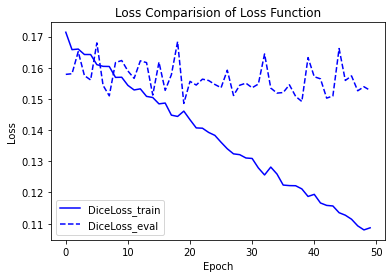

In [16]:
x=np.arange(50)
colors=[['b-','b--'],['g-','g--'],['y-','y--'],['r-','r--']]
for i in range(1):
    plt.plot(x,Losses[i][0],colors[i][0],label=names[i]+'_train')    
    plt.plot(x,Losses[i][1],colors[i][1],label=names[i]+'_eval')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Comparision of Loss Function')
    plt.legend()
    plt.show()

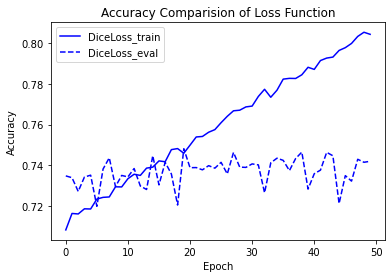

In [17]:
for i in range(1):
    plt.plot(x,Accuracies[i][0],colors[i][0],label=names[i]+'_train')    
    plt.plot(x,Accuracies[i][1],colors[i][1],label=names[i]+'_eval')
    
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparision of Loss Function')
plt.legend()
plt.show()

In [18]:
num_figure=8
imgs=np.arange(num_figure)*10
unet=UNet().cuda()

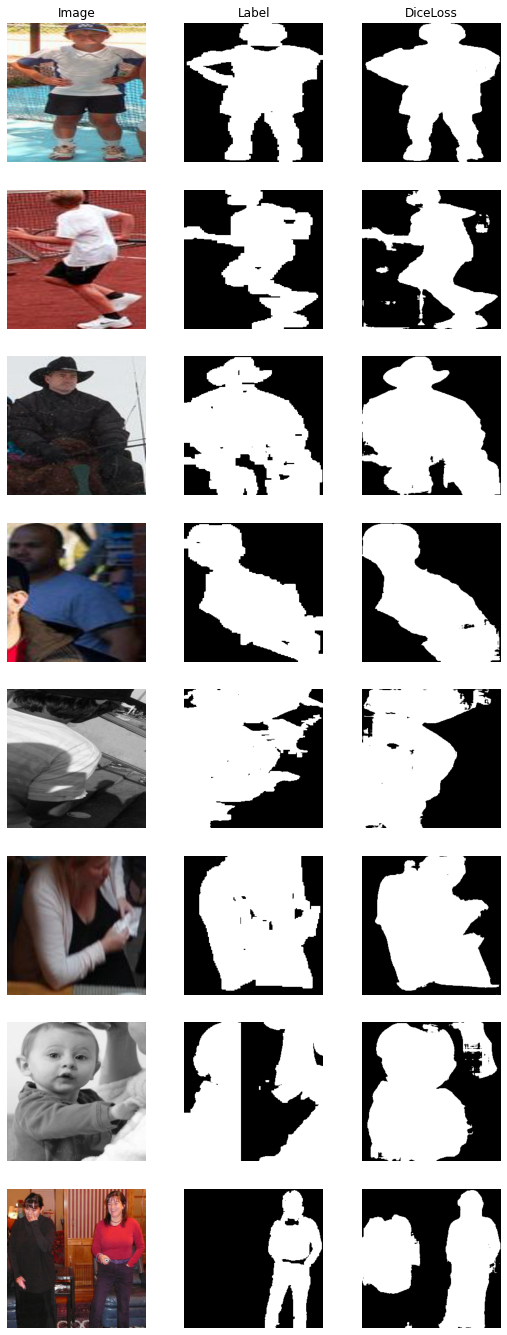

In [23]:
plt.figure(figsize=(9,24))

count=1

for i in imgs:
    
    im,label=train_data.__getitem__(i)
    
    plt.subplot(num_figure,3,count)
    plt.imshow(np.transpose(im.numpy(),(1,2,0)))
    count+=1
    if i==0:
        plt.title('Image') 
    
    
    plt.subplot(num_figure,3,count)
    plt.imshow(label.numpy()[0],cmap = plt.get_cmap('gray'))
    count+=1
    if i==0:
        plt.title('Label')
    
    for j in range(1):
      
        unet.load_state_dict(torch.load('./w'+str(j)+'.pkl'))
        plt.subplot(num_figure,3,count)
        img=torch.unsqueeze(im,dim=0)
        b_x=Variable(img).cuda()
        output=unet(b_x).to(torch.float64)
        plt.imshow(output.cpu().detach().numpy()[0][0],cmap = plt.get_cmap('gray'))
        if i==0:
            plt.title(names[j]) 
        count+=1

plt.show()

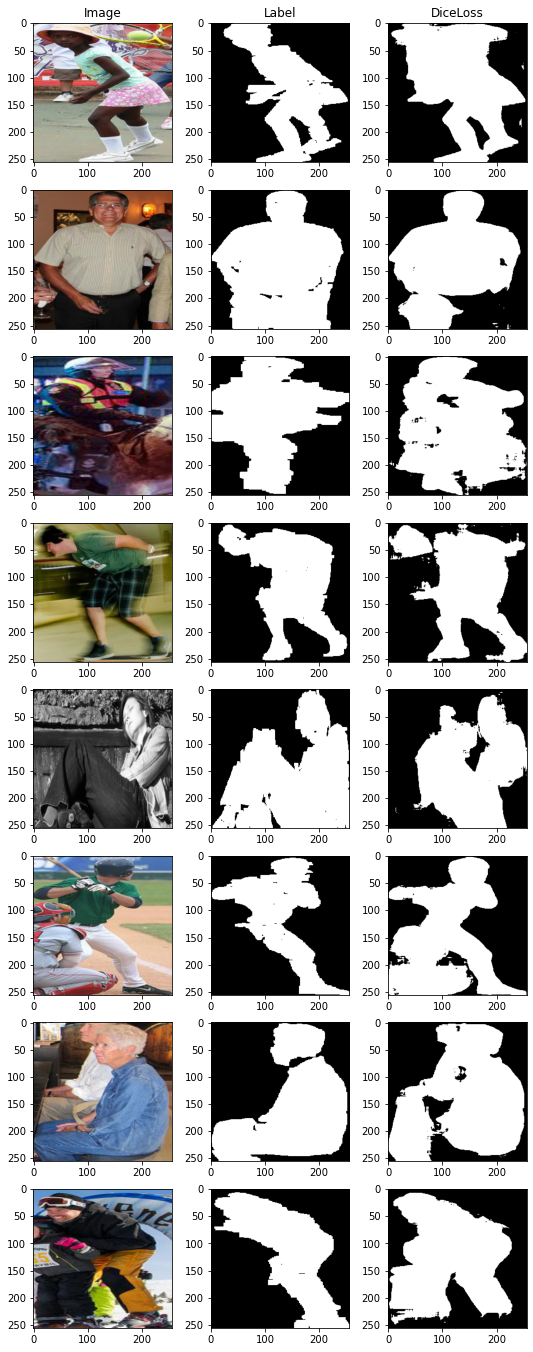

In [20]:
plt.figure(figsize=(9,24))

count=1

for i in imgs:
    
    im,label=eval_data.__getitem__(i)
    
    plt.subplot(num_figure,3,count)
    plt.imshow(np.transpose(im.numpy(),(1,2,0)))
    count+=1
    if i==0:
        plt.title('Image')     
    
    
    plt.subplot(num_figure,3,count)
    plt.imshow(label.numpy()[0],cmap = plt.get_cmap('gray'))
    count+=1
    if i==0:
        plt.title('Label')
    
    for j in range(1):
       
        unet.load_state_dict(torch.load('./w'+str(j)+'.pkl'))
        ax=plt.subplot(num_figure,3,count)
        img=torch.unsqueeze(im,dim=0)
        b_x=Variable(img).cuda()
        output=unet(b_x).to(torch.float64)
        plt.imshow(output.cpu().detach().numpy()[0][0],cmap = plt.get_cmap('gray'))    
        count+=1
        if i==0:
            plt.title(names[j]) 


plt.show()


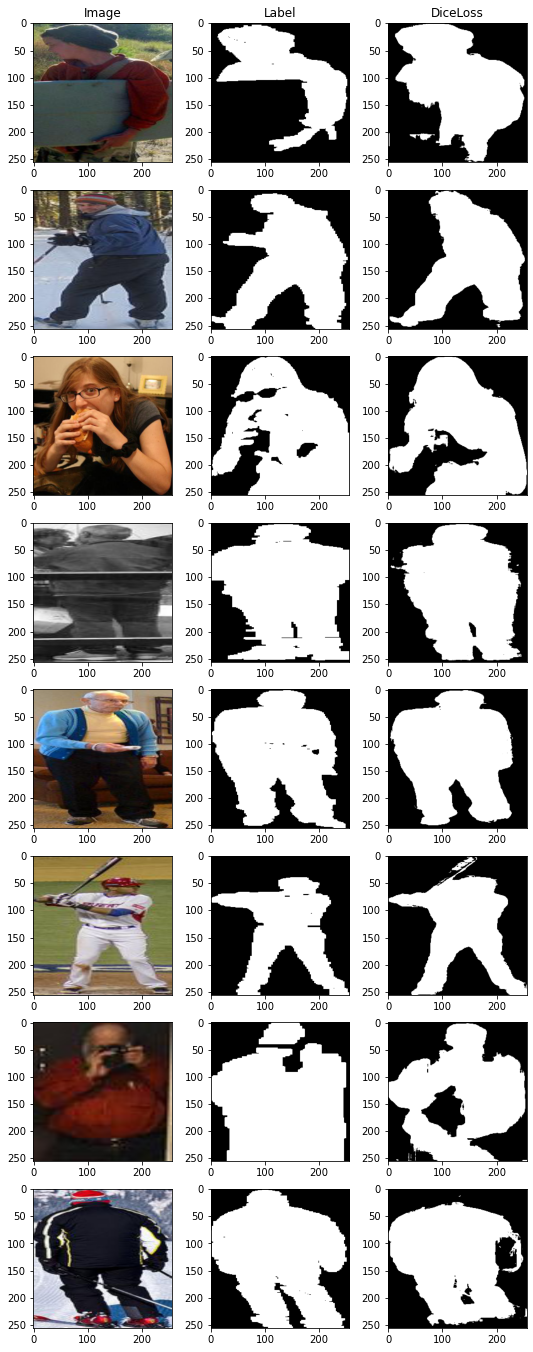

In [21]:
test_data=MyDataSet('test',test_transfrom)
plt.figure(figsize=(9,24))

count=1

for i in imgs:
    
    im,label=test_data.__getitem__(i)
    
    plt.subplot(num_figure,3,count)
    plt.imshow(np.transpose(im.numpy(),(1,2,0)))
    count+=1
    if i==0:
        plt.title('Image') 
    
    plt.subplot(num_figure,3,count)
    plt.imshow(label.numpy()[0],cmap = plt.get_cmap('gray'))
    count+=1
    if i==0:
        plt.title('Label') 
    
    for j in range(1):
        
        unet.load_state_dict(torch.load('./w'+str(j)+'.pkl'))
        plt.subplot(num_figure,3,count)
        img=torch.unsqueeze(im,dim=0)
        b_x=Variable(img).cuda()
        output=unet(b_x).to(torch.float64)
        plt.imshow(output.cpu().detach().numpy()[0][0],cmap = plt.get_cmap('gray'))    
        if i==0:
            plt.title(names[j]) 
        count+=1

plt.show()